# Wedge Dropout
*Wedge Dropout drives apart CNN feature maps which are too close together.*


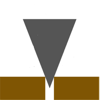


## Abstract

Wedge Dropout improves a CNN network by examining pairs of output feature maps and providing negative feedback if they are strongly correlated. 
Wedge Dropout is effective in almost all Convolutional Neural Network pipelines. Preliminary testing has shown that it can give a very slight improvement to model accuracy, generally 0.05% to 0.1%, in many different 1D, 2D and 3D CNN-based models. Usually no hyperparameter tuning is required to achieve this improvement. Wedge Dropout has no run-time overhead. Like other Dropout algorithms, it is only active during training.





## Abstract
Convolutional Neural Networks (CNNs) operate by creating a set of independent *feature maps*. These are representations of various features that recur in the dataset used to train the network. Collectively, this set of feature maps serves as a description of the features of an image. The feature maps should be decorrelated- any redundancy in the feature maps degrades the predictive power of the network. 

Wedge Dropout is Dropout algorithm designed for convolutional networks. The algorithm measures the corelation among the set of feature maps generated by a CNN, and encourages any strongly correlated feature maps to become less correlated. It is effective in almost all convolutional Network pipelines, usually without any tuning of hyperparameters. Preliminary testing has shown that it can give a very slight improvement to model accuracy, generally 0.05% to 0.1%, in many different 1D, 2D and 3D CNN-based models. Wedge Dropout has no run-time overhead. Like other Dropout algorithms, it is only active during training.




## Introduction
Wedge Dropout is a Dropout algorithm tuned for convolutional networks.
It improves a CNN by providing feedback during training; this is a recent innovation in Dropout algorithms.

A CNN works by generating summaries based on an input dataset. These summaries are called "feature maps". For example, given a picture of a cat, one feature map outlines the head, another the eyes, a third the chin. Collectively they describe aspects of the cat. Feature maps should be independent- if they are correlated, or "too similar", the CNN describes fewer unique aspects than it could. 

The Wedge Dropout algorithm works by analyzing the final output of a convolutional neural network (CNN). Where Spatial Dropout zeroes out randomly chosen feature maps, Wedge Dropout analyzes randomly chosen pairs of feature maps and applies negative feedback to both when they are "too similar".






![cat head](../pics/cat_feature_wedge_4.jpg)

As an example, here is a picture of two different feature maps that were generated for the same image of a cat's face by a convolutional neural network. They "outline" the contours of the side of the cat's head, where it joins the neck. Note that the two feature maps are very similar, but are not the same. Since these feature maps are so similar, they are redundant in function. Wedge Dropout will find this pair of feature maps during training, and via negative feedback will drive them apart so that they describe slightly different aspects of this part of the cat's body. The effect is small but measurable.



## Similar Work
Wedge Dropout is a combination of two recent trends in dropout research: CNN-specific dropout strategies and critiquing feature maps.
### CNN-Specific Dropout Strategies
SpatialDropout and Dropblock are dropout strategies specifically designed around the nature of CNN feature maps. CNN feature maps are strongly correlated within the feature map, but different feature maps are not strongly correlated. 
#### *SpatialDropout*
SpatialDropout zeroes out randomly chosen feature maps, to discourage them from becoming too correlated. It is best used right after the first convolutional layer.
#### *DropBlock*
DropBlock randomly chooses sub-rectangles in feature maps and randomly zeroes them out. Again, this discourages feature maps from becoming strongly correlated. It is not clear where it should be used in the network.
### Critiquing Feature Maps
It is possible to analyze feature maps and provide feedback when some of them become non-performant. This seems to be a recent invention.

Under this method, a layer scores all of the feature maps generated for an image. The score determines whether the feature map will be interfered with in some way. It could be zeroed out entirely, or the scoring function could indicate a specific region of the feature map that should be disrupted. We will examine two of these, CamDrop and InfoDrop.

#### *CamDrop*
In CamDrop, feature maps are analyzed and then a rectangular region is zeroed out in multiple, but not all, feature maps. This clearly can discourage correlation.
#### *InfoDrop*
CNNs are notorious for fixating on textural features to the detriment of spatial features. InfoDrop (Informative Dropout) addresses this by finding regions of a feature map which correspond to a texture in the original image. It then applies negative feedback via "fuzzing" the offending section of the feature map.
### Summary

In a sense, Wedge Dropout is to Spatial Dropout as CamDrop is to DropBlock: it replaces randomized dropout with a scoring mechanism based on analyzing feature maps. Wedge Dropout was directly inspired by SpatialDropout and CamDrop.


## Algorithms
CNN feature maps generally have a low-valued "background" and high-valued "hills", where the hills are the feature(s) found in the original image. Two algorithms were investigated for Wedge Dropout's analysis phase. Both specifically ignore the background and only compare the hills, by using the mean value. It is not clear whether either algorithm is more robust across different CNN use cases.
### Direct Comparison
This algorithm isolates the cells in each feature map which are above its mean value, and then compares individual values across both feature maps cell by cell in a simple Boolean AND operation. This counts the number of cells in both feature maps that tend to find the same feature. If this count is above a certain percentage of the total number of cells in the feature map, both feature maps are zeroed out.
### Normalize and Multiply
This algorithm normalizes both feature maps to a range from 0.0 to 1.0, multiplies the two feature maps cellwise (Hadamard matrix multiplication), and counts the number of values above the mean of the resulting output. Again, if more than a certain percentage are above the mean, both feature maps are zeroed out.

Following are implementations of each algorithm in Python, using the following feature maps:

In [2]:
import numpy as np

fmap1 = np.asarray([[1,2],[3,4]])
fmap2 = np.asarray([[3,1],[4, 9]])

print('Feature Map #1')
print(fmap1)
print('Feature Map #2')
print(fmap2)

Feature Map #1
[[1 2]
 [3 4]]
Feature Map #2
[[3 1]
 [4 9]]


In [3]:
def similarity_direct_comparison(img1, img2):
    mean1 = np.mean(img1)
    mean2 = np.mean(img2)

    visible1 = img1 > mean1
    visible2 = img2 > mean2

    correlated = visible1 == visible2

    percentage = sum(correlated.flatten()) / len(img1.flatten())

    return percentage

def similarity_multiply(img1, img2):
    zero1 = img1 - np.min(img1)
    zero2 = img2 - np.min(img2)
    norm1 = zero1 / (np.linalg.norm(zero1) + 0.0001)
    norm2 = zero2 / (np.linalg.norm(zero2) + 0.0001)
    # normalized maps are now in the same range
    mult = norm1 * norm2
    avg = np.median(mult)
    correlated = mult > avg

    percentage = sum(correlated.flatten()) / len(img1.flatten())
    return percentage

percentage1 = similarity_direct_comparison(fmap1, fmap2)
print('Direct Comparison similarity score:', percentage1)
percentage2 = similarity_multiply(fmap1, fmap2)
print('Normalize and Multiply similarity score:', percentage2)



Direct Comparison similarity score: 0.75
Normalize and Multiply similarity score: 0.5


We can see that the two algorithms provide different interpretations of 'correlated'. 

# Results
Results for several different Keras examples, rewritten for tuning, and with a head-to-head comparison of with and without Wedge Dropout. 


<table>
<caption>Table 1 - Measurements of the impact of Wedge Dropout on loss and accuracy values</caption>
<tr><th>Keras Example</th>
<th>Type</th>
<th>Loss base</th>
<th>Loss test</th>
<th></th>
<th>Accuracy base</th>
<th>Accuracy test</th>
<th>Accuracy Delta %</th>
<th>Notes</th>
</tr>
<tr>
 <td><a href="https://github.com/LanceNorskog/keras-wedge/blob/main/notebooks/Wedge2D_Demo_vae.ipynb">VAE with WedgeDropout in decoder</a></td>
  <td>Base</td>
  <td>6.8831</td>
  <td>6.0036</td>
  <td> </td>
  <td>0.8112</td>
  <td>0.8261</td>
  <td>1.49%</td>
  <td> </td>
</tr>
 <td><a href="https://github.com/LanceNorskog/keras-wedge/blob/main/notebooks/WedgeDropout1D_Demo_timeseries_anomaly_detection.ipynb">Timeseries anomaly detection using an Autoencoder</a></td>
  <td>Validation</td>
  <td>0.0049</td>
  <td>0.0029</td>
  <td> </td>
  <td/><td/><td/><td/>
</tr>
<tr>
<td><a href="https://github.com/LanceNorskog/keras-wedge/blob/main/notebooks/WedgeDropout1D_Demo_timeseries_classification_from_scratch.ipynb">Timeseries classification from scratch</a></td>
  <td>Validation</td>
  <td>0.1921</td>
  <td>0.1059</td>
  <td> </td>
  <td>0.9189</td>
  <td>0.9621</td>
  <td>4.32%</td>
</tr>
<tr>
 <td><a href="https://github.com/LanceNorskog/keras-wedge/blob/main/notebooks/WedgeDropout1D_Demo_transformer_asr.ipynb">Automatic Speech Recognition with Transformers</a></td>
  <td>Validation</td>
  <td>0.7396</td>
  <td>0.6854</td>
  <td> </td>
  <td/><td/><td/><td/>
</tr>
<tr>
 <td><a href="https://github.com/LanceNorskog/keras-wedge/blob/main/notebooks/Wedge_oxford_pets_image_segmentation.ipynb">Image segmentation with a U-Net-like architecture</a></td>
  <td>Validation</td>
  <td>0.4046</td>
  <td>0.4180</td>
  <td> </td>
  <td>0.3018</td>
  <td>0.3326</td>
  <td>3.08%</td>
</tr>
<tr>
 <td><a href="https://github.com/LanceNorskog/keras-wedge/blob/main/notebooks/WedgeDropout2D_demo_xray_classification_with_tpus.ipynb">Pneumonia Classification on TPU</a></td>
  <td>Validation</td>
  <td>0.1404</td>
  <td>0.0935</td>
  <td> </td>
  <td>0.9651</td>
  <td>0.9738</td>
  <td>0.87%</td>
  <td/>
</tr>
<tr>
 <td><a href="https://github.com/LanceNorskog/keras-wedge/blob/main/notebooks/WedgeDropout1D_demo_pointnet.ipynb">Point cloud classification with PointNet</a></td>
  <td>Validation</td>
  <td>0.6674</td>
  <td>0.7731</td>
  <td> </td>
</tr>
<tr>
 <td><a href="https://github.com/LanceNorskog/keras-wedge/blob/main/notebooks/WedgeDropoutLSTM2D_next_frame_with_conv_lstm.ipynb">Next-frame prediction with Conv-LSTM</a></td>
  <td>Validation</td>
  <td>0.0170</td>
  <td>0.0054</td>
  <td> </td>
  <td>0.9955</td>
  <td>0.9983</td>
  <td>0.23%</td>  
  <td>700 epochs,stopped at 2300 epochs</td>
</tr>
<tr>
 <td><a href="https://github.com/LanceNorskog/keras-wedge/blob/main/notebooks/WedgeDropout2D_captcha_ocr.ipynb">OCR model for reading Captchas</a></td>
  <td>Loss</td>
  <td>0.2946</td>
  <td>0.2465</td>
  <td> </td>
  <td> </td>
  <td> </td>
  <td> </td>  
</tr>
<tr>
 <td><a href="https://github.com/LanceNorskog/keras-wedge/blob/main/notebooks/WedgeDropout2D_siamese_contrastive.ipynb">Image similarity using Siamese plus contrastive</a></td>
  <td>Loss</td>
  <td>0.0134</td>
  <td>0.0128</td>
  <td> </td>
  <td>0.9833</td>
  <td>0.9840</td>
  <td>0.07%</td>  
</tr>
</table>

loss: 0.0134 - accuracy: 0.9833
0128 9840

Training notes:
* The Keras examples are just that, examples. They are not intended as production models. There are various problems that make it harder to test Wedge Dropout in an a/b test:
** Some models do not include an accuracy measurement. Loss is a unitless number. Wedge Dropout models usually have increased loss at the beginning and decreased loss at the end, compared to the base model. This is due to large amounts of negative feedback at the beginning, and overall higher quality of the model at the end.
** Some models do not include a validation dataset.
** Some models have very small datasets, or are a "toy" problem.
** The models are generally shallow.
*** This is important because Wedge Dropout does not do well on tests of deeper networks. It is possible that the negative feedback is not apportioned well across deep stacks of convolutions, or in recurrent networks.
* Wedge Dropout only does well at the end of a model. When the CNN chain ends in the middle of the model, for example the Siamese Contrastive Similarity model, it does not give improvements.
* Wedge Dropout can increase the loss, to compensate for this some models needed a smaller learning rate for the Wedge Dropout version.
* Wedge Dropout works better with large batches, so most of the examples are changed to large memory configurations with batch sizes as large as possible. This also improves BatchNormalization, so it benefits both base and test versions.
* Earlier versions of Tensorflow could have much longer times for the compilation graph, and longer execution times, when the Wedge Dropout layer is added. This is not as visible with 2.5.0.
* Later versions of Tensorflow seem to have better performance (predictive power) for the original models, and the difference made by Wedge Dropout was not as visible. 
* The WedgeDropout layer code triggered a TPU compilation error in earlier Tensorflow versions. It works starting with Tensorflow 2.5.0, and only without a final "odd lot" batch size. (It does not work in the early release of 2.6.0-rc1, and an issues is filed with the Keras project.)

# Usage
Wedge Dropout operates by critiquing the values created by the CNN pipeline, and is best used at the end of a pipeline of CNN layers. 

*Note: Lift a standard CNN diagram and poke in a Wedge Dropout layer right before the final Dense/GlobalAveragePooling layer.*

Wedge Dropout only has one hyperparameter, the similarity coefficient. Preliminary testing on many different 1D, 2D and 3D CNN networks has shown that one value is optimal for almost all applications: 0.5 for the Direct Comparison algorithm, and 0.65 for the Normalize and Multiply algorithm.

# Batch-wise Operation and Batch Normalization
It has proven effective to apply Wedge Dropout to all of the feature maps for a pair of random indexes, and then do a simple voting algorithm on the results. For example, if the batch size is 32, then if 16 pairs of feature maps are "too similar", then all 32 feature maps are zeroed out. If only 15 pairs are too similar, none of the feature maps are zeroed out.

When operating per sample, Wedge Dropout critiques a pair of feature maps. In batch-wise operation, Wedge Dropout critiques the engine, or causal chain, that created the feature maps. 

Batch Normalization is a proven method of improving a CNN model, and is used in most reference architectures except image generators. Batch Normalization's performance improves as the batch size increases. Wedge Dropout's performance also increases as batch size increases, so it is a good match for existing CNN architectures. Like Spatial Dropout and other CNN-specific Dropout algorithms, do not place a Batch Normalization layer after a Wedge Dropout layer. Wedge Dropout works well after a Batch Normalization layer. All successful tests have placed the Wedge Dropout layer right before the final summarization layer, usually a Dense or GlobalAveragePooling layer. 


# Further Research
## Algorithms
* There may be other similarity functions appropriate for CNN feature maps.
* There may be a better technique than 'median' or 'mean' for determining the "interesting" parts of a feature map.

## Dropout Style
"Slice Dropout" [ https://arxiv.org/pdf/2006.16571.pdf ], a variant of Spatial Dropout, zeroes out only one half of a feature map instead of the entire feature map. A more complex version of Wedge Dropout's feature map comparison could decide that all of the offending cells are concentrated on one side of the feature map, or even just one quadrant. It would choose to zero out only that area.

It is possible that zeroing out values is not the only way to affect training. There may be ways to do a random fill which do not disrupt the operation of Batch Normalization. InfoDrop uses a selective fuzzing technique to disrupt feature maps which respond to textures. This might be useful to Wedge Dropout.

### Feature Maps and Attention Heads
The multi-head attention architecture [ https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf ] creates multiple "answer" vectors of the same size, and combines them with addition. This set of vectors shares a property with a set of feature maps: the information within the vector is strongly correlated, but information across vectors should not be correlated. If the information is correlated across attention heads, the attention heads are learning the same answer set. It is possible that Wedge Dropout, or even Spatial Dropout, will improve the function of a multi-head attention model, given an appropriate similarity function.

# Concluding Remarks
## Time added to training
The Wedge Dropout algorithm can add a noticeable increase in tensor graph compilation time, and training time per epoch. For example, the final phase of EfficientNet "Zero" generates 1024 feature maps, and then applies GlobalAveragePooling to those. Wedge Dropout was most effective when inserted between the final convolution layer and the GlobalAveralPooling layer. Adding Wedge Dropout increased the tensor graph compilation phase by 20%, and added 10%-15% to the running time for each epoch. This effect seems to be reduced in recent Tensorflow releases.

Wedge Dropout is not active during prediction, and does not contribute any values that need to be loaded for a model. The Wedge Dropout layer can be stripped out of an inference-only version of the model. (As it happens, the Tensorflow *smart_cond()* feature that is used for the *trainable* flag requires that the analysis code be executed and ignored during production. Thus, a Tensorflow production model really should be a separate architecture based on the training version!)

## Quantity of feature maps
The algorithm simply chooses N/2 pairs of feature maps on each epoch. In networks which create large numbers of feature maps, it is possible that Wedge Dropout should apply the similarity function to more pairs. For example, N/8 * log(N) would give a similar number for small networks but an interesting number of comparisons for larger networks.

Since Wedge Dropout makes feature maps (slightly) more expressive, it is possible that it could allow a model to achieve the required performance with fewer feature maps.

## Batch-oriented Operation
We have found it worthwhile compare the same pair of feature maps for every sample in a batch, and apply simple voting to decide whether to apply negative feedback to all of the samples. It is useful to consider the CNN as an engine that creates feature maps: by doing this we apply negative feedback at a feature map level, not per sample. This voting system increases in power as the batch size increases. BatchNormalization also improves with batch size, so this is a synergetic design. We should note that zeroing out the feature maps "confuses" BatchNormalization when placed before BatchNormalization, and so there should be no BatchNormalization layers after the Wedge Dropout layer.

## Utility
Wedge Dropout is not needed for any image architecture. However, given the lack of complex hyperparameters and simplicity of application, it will probably improve most production uses of CNNs.
It has been tested with many example networks in the Keras documentation, and worked in all Conv1D, Conv2D and Conv3D-based applications. It did not improve a multi-layer fully trained networks (EfficientNet Level 0), but did improve an application which uses pre-trained ImageNet layers. It also did not help with LSTM2D. Given the lack of complex hyperparameters and simplicity of application, it should be useful in many production applications of convolutional neural nets.

Since Wedge Dropout works by critiquing the output of a CNN, it is possible that its feedback only works in a simple causal chain. It is possible that the causal graph of feature map creation is turbid in deep networks and 2D LSTMs; perhaps some other method of negative feedback would be more effective. 

# Conclusion
Wedge Dropout is a very robust technique for improving the operation of almost any convolutional neural network. It critiques the set of feature maps created by a CNN with a scoring function (similarity of pairs) and applies negative feedback to improve the decorrelation of feature maps. It usually requires no hyperparameter tuning- it has been tested in 1D, 2D and 3D networks and the default tuning parameter was optimal. With some care, it coexists well with standard CNN techniques like BatchNormalization.

# Citations
[ CNN ](https://arxiv.org/pdf/1404.7828.pdf)

[ Dropout ](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)

[ CamDrop ](https://dl.acm.org/doi/10.1145/3357384.3357999)

[ DropBlock ](https://papers.nips.cc/paper/8271-dropblock-a-regularization-method-for-convolutional-networks.pdf)

[ InfoDrop ](https://arxiv.org/abs/2008.04254)

[ SpatialDropout paper ](https://arxiv.org/pdf/1411.4280.pdf)

[ SpatialDropout Keras man page ](https://keras.io/api/layers/regularization_layers/spatial_dropout2d/)